# Rossman Sales Forecasting
### Pujan Malavia

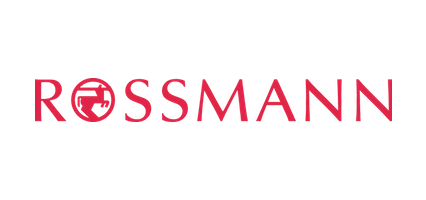

In [14]:
from IPython.display import display
from PIL import Image
path= "C:/Users/puj83/OneDrive/Portfolio/Rossman_Store_Sales/rossman.png"
display(Image.open(path))

### Link to Dataset:
https://www.kaggle.com/c/rossmann-store-sales/data

### Abstract:
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Industry:
Retail

### Company Information:
Dirk Rossmann GmbH is Germany's second-largest drug store chain (after dm-drogerie markt), with over 3,790 stores in Europe.

Rossmann was founded in 1972 by Dirk Rossmann.

The Rossmann family owns 60%, and the Hong Kong-based A.S. Watson Group 40% of the company. The company headquarters are in the German town of Burgwedel near Hanover.

https://en.wikipedia.org/wiki/Rossmann_(company)
https://www.aswatson.com/our-brands/health-beauty/rossmann/#.XUd5uuhKhGM

### Use Case:
Predicting their daily sales for up to six weeks in advance.

### Tool:
Python (Jupyter Notebook)

### Initial Dataset:
train.csv - historical data including Sales

test.csv - historical data excluding Sales

sample_submission.csv - a sample submission file in the correct format

store.csv - supplemental information about the stores

### Data:
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

### Data Fields:

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 

E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
# !pip install numpy==1.17.0
# !pip install xgboost
# !conda install libpython m2w64-toolchain -c msys2
# !pip install pystan
# !pip install fbprophet
# !pip install seaborn

### Import Libraries

In [162]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time
import os
# statistics
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from fbprophet import Prophet
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from pandas import DataFrame

### Import Dataset(s)

In [199]:
train = pd.read_csv('C:/Users/puj83/OneDrive/Portfolio/Rossman_Store_Sales/train.txt',parse_dates=[2], low_memory = False)
test = pd.read_csv('C:/Users/puj83/OneDrive/Portfolio/Rossman_Store_Sales/test.txt',parse_dates=[2], low_memory = False)
store = pd.read_csv('C:/Users/puj83/OneDrive/Portfolio/Rossman_Store_Sales/store.txt',parse_dates=[2], low_memory = False)

In [200]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [201]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [202]:
store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [203]:
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

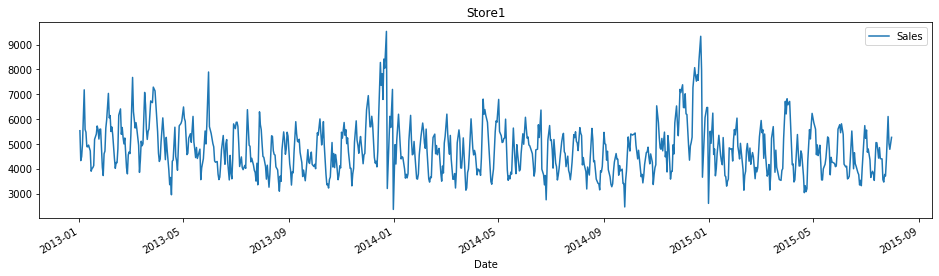

In [204]:
# sales of store1 full timne
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

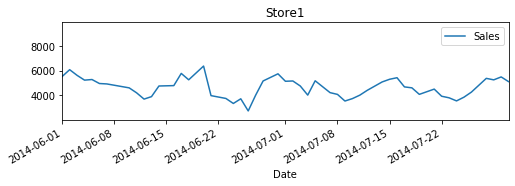

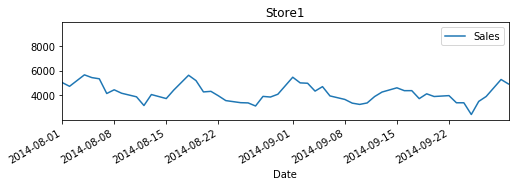

In [205]:
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])

In [206]:
# the store should be open in the test,so we fillna with 1
test.fillna(1, inplace=True)

In [207]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

In [208]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [209]:
train1 = train

In [210]:
train1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [211]:
train2 = pd.merge(train1, store, on='Store')    ## for TimeSeries Arima Model
train2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [212]:
df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

In [213]:
train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2['Sales/Customer'].describe()

df_train_store['Sales/Customer'] = df_train_store['Sales']/df_train_store['Customers']

In [214]:
def features_create(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [215]:
# iterating the columns 
for col in df_train_store.columns: 
    print(col) 
for col in df_test_store.columns: 
    print(col) 
df_test_store['Date'].dtypes
df_train_store['Date'].dtypes
df_test_store['Date']= pd.to_datetime(df_test_store['Date']) 

Id
Store
DayOfWeek
Date
Open
Promo
StateHoliday
SchoolHoliday
StoreType
Assortment
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2
Promo2SinceWeek
Promo2SinceYear
PromoInterval


In [216]:
features_create(df_train_store)
features_create(train2)
features_create(df_test_store)
print('Features creation finished')
# train.head()

Features creation finished


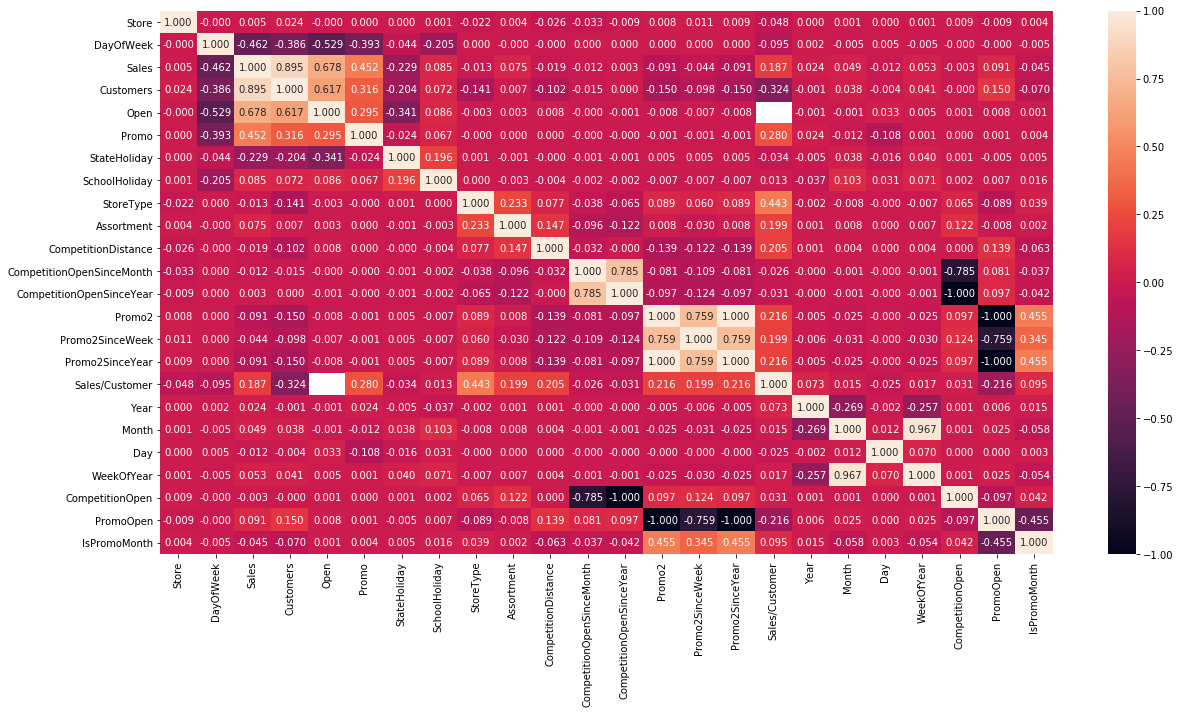

In [217]:
plt.figure(figsize = (20, 10))
sns.heatmap(df_train_store.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(df_test_store.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')

In [218]:
train2 = train2.set_index('Date')

In [219]:
train2.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,3,1,...,,9.482883,2015,7,31,31,82.0,24187.75,Jul,0
2015-07-30,1,3,5020,546,1,1,0,1,3,1,...,,9.194139,2015,7,30,31,82.0,24187.75,Jul,0
2015-07-29,1,2,4782,523,1,1,0,1,3,1,...,,9.143403,2015,7,29,31,82.0,24187.75,Jul,0
2015-07-28,1,1,5011,560,1,1,0,1,3,1,...,,8.948214,2015,7,28,31,82.0,24187.75,Jul,0
2015-07-27,1,0,6102,612,1,1,0,1,3,1,...,,9.970588,2015,7,27,31,82.0,24187.75,Jul,0


In [220]:
train2['Sales'] = train2['Sales'] * 1.0

In [221]:
sales_a = train2[train2.Store == 2]['Sales']
sales_b = train2[train2.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train2[train2.Store == 1]['Sales']
sales_d = train2[train2.Store == 13]['Sales']

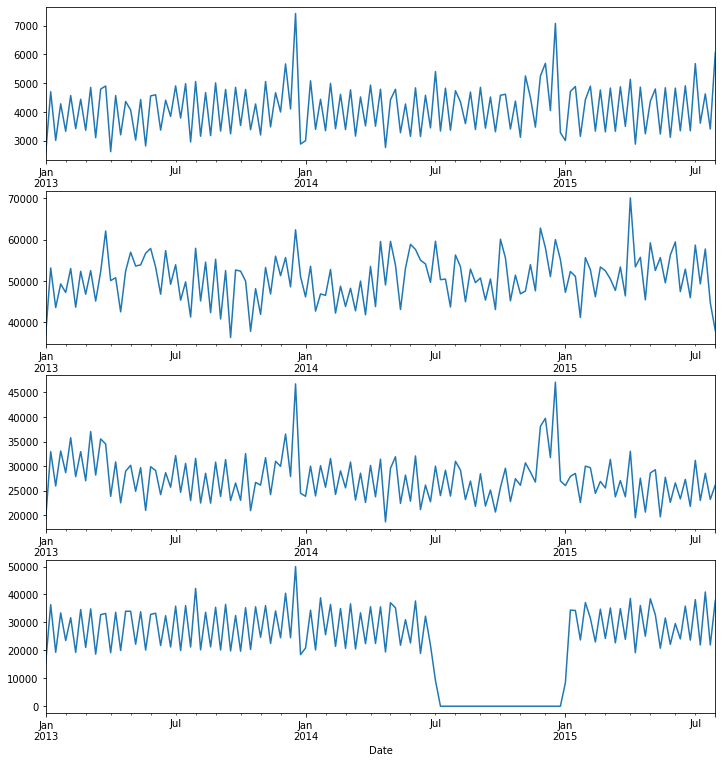

In [222]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').mean().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

In [223]:
rollmean = sales_a.rolling(window=7).mean()
rollstd = sales_a.rolling(window=7).std()

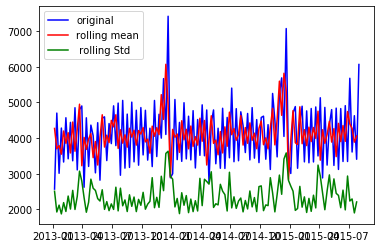

In [224]:
orig = plt.plot(sales_a.resample('W').mean(),color='blue',label='original')
roll_mean = plt.plot(rollmean.resample('W').mean(),color='red',label='rolling mean')
orig_std = plt.plot(rollstd.resample('W').mean(),color='green',label=' rolling Std')
plt.legend(loc='best')
plt.show(block=False)

In [225]:
from statsmodels.tsa.stattools import adfuller
def stationary_check(sales):
  result = adfuller(sales,autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	   print(key, value)

In [226]:
stationary_check(sales_a)
stationary_check(sales_b)
stationary_check(sales_c)
stationary_check(sales_d)

ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [227]:
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=360)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid



    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')

    plt.title('Decomposition for StoreType')

C:\Users\puj83\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


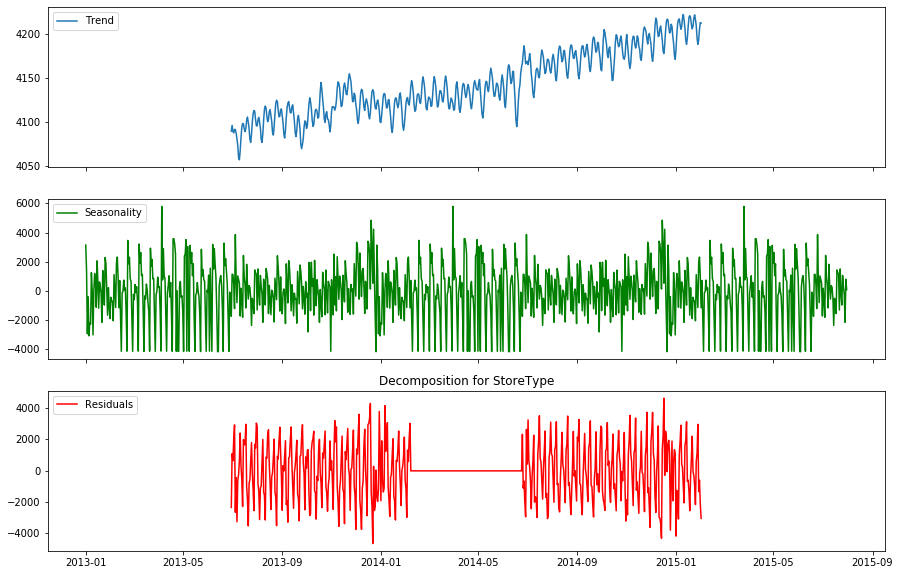

In [228]:
plot_timeseries(sales_a,'a')

C:\Users\puj83\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


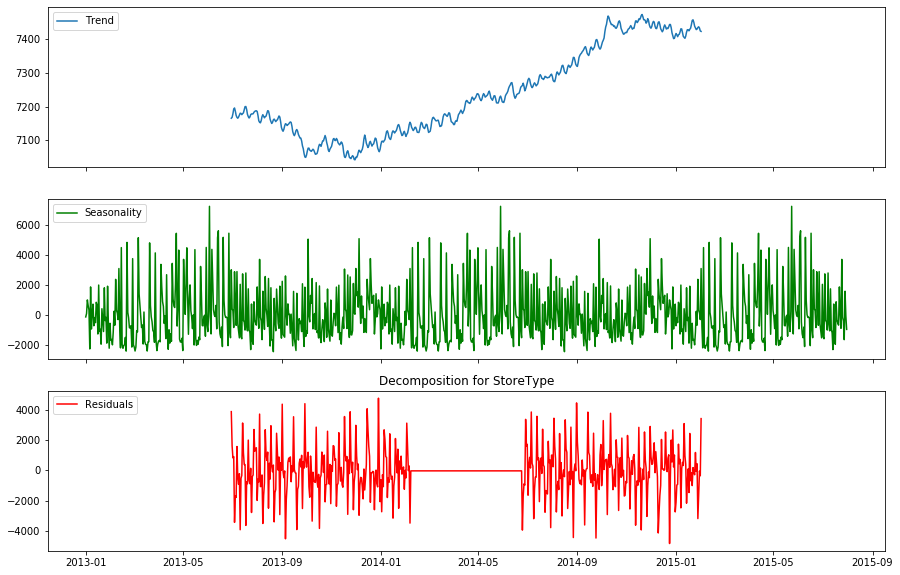

In [229]:
plot_timeseries(sales_b,'b')

C:\Users\puj83\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


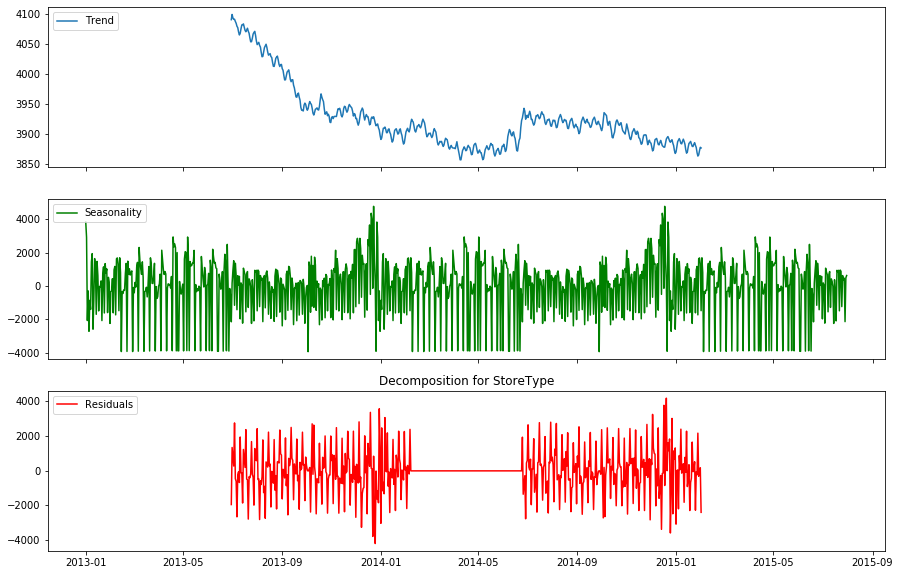

In [230]:
plot_timeseries(sales_c,'c')

C:\Users\puj83\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


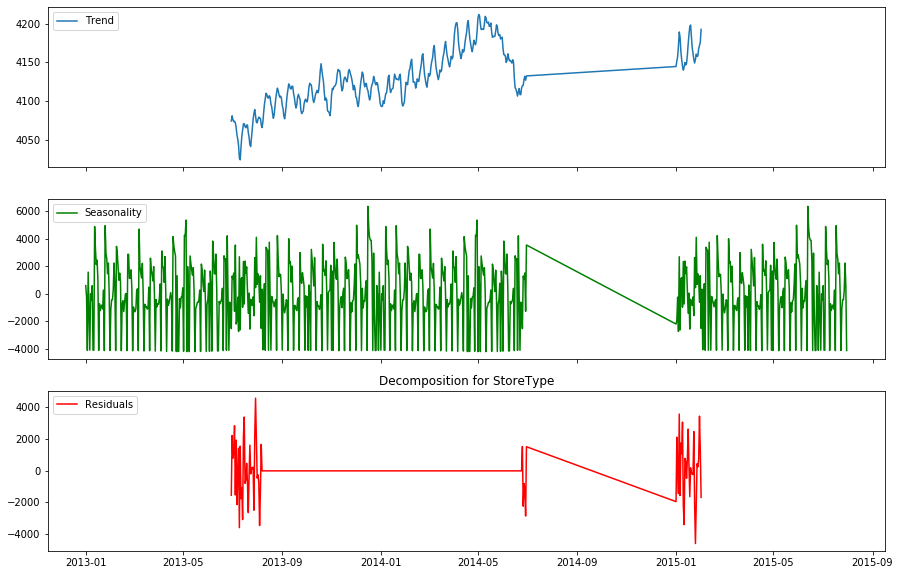

In [231]:
plot_timeseries(sales_d,'d')

In [232]:
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')


    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

C:\Users\puj83\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


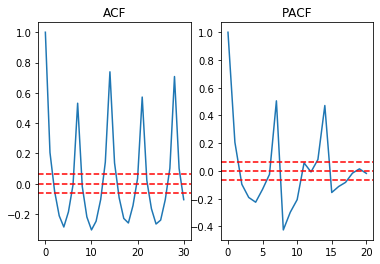

In [233]:
auto_corr(sales_a)

C:\Users\puj83\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


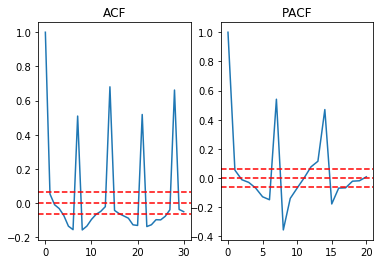

In [234]:
auto_corr(sales_b)

C:\Users\puj83\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


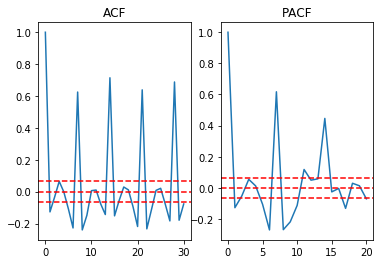

In [235]:
auto_corr(sales_c)

C:\Users\puj83\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


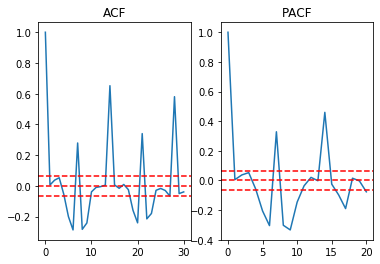

In [236]:
auto_corr(sales_d)

In [237]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [238]:
def sample(sales):
  return(sales.resample('MS').mean())

In [239]:
y_sale_a = sample(sales_a)
y_sale_b = sample(sales_b)
y_sale_c = sample(sales_c)
y_sale_d = sample(sales_d)

In [240]:
def model(i,sale):
  ex = train2.loc[train2['Store'] == i,['Customers','Promo']]
#   ex = train2.loc[train2['Store'] == i]
#   ex.drop(['Open','PromoInterval','monthStr','Customers'],axis=1,inplace =True)
  y_sales = sale.resample('MS').mean()
  y_ex = ex.resample('MS').mean()
  exog = sm.add_constant(y_ex)
  exog.tail()
  return y_sales , exog

In [241]:
y_sale_model_a , exog_a = model(2,sales_a)
y_sale_model_b , exog_b = model(85,sales_b)
y_sale_model_c , exog_c = model(1,sales_c)
y_sale_model_d , exog_d = model(13,sales_d)

In [242]:
exog_a = exog_a.dropna()
exog_a.isna().sum()

exog_b = exog_b.dropna()
exog_b.isna().sum()

exog_c = exog_c.dropna()
exog_c.isna().sum()

exog_d = exog_d.dropna()
exog_d.isna().sum()

const        0
Customers    0
Promo        0
dtype: int64

In [243]:
def arima(y_sale,exog,or1,sord):
    mod = sm.tsa.statespace.SARIMAX(y_sale,
                                    exog,
                                    order=or1,
                                    seasonal_order=sord,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)



    results = mod.fit(disp=0)
    ## -----------------------predictions-------------------
    pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'), dynamic=False)
    pred_ci = pred.conf_int()

   ##------------------------plot-----------------------------
    ax = y_sale['2013':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                      pred_ci.iloc[:, 1],
                      pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('sales')
    plt.legend()

    plt.show()


    y_forecasted = pred.predicted_mean
    y_truth = y_sale['2015-01-01':'2015-07-01']

   ##-------------Compute the mean square error----------------
    mse = ((y_forecasted - y_truth) ** 2).mean()
    rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
    rmspe =  np.sqrt(np.mean((y_forecasted/y_truth) ** 2))
    return results , mse,rmse,rmspe

C:\Users\puj83\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


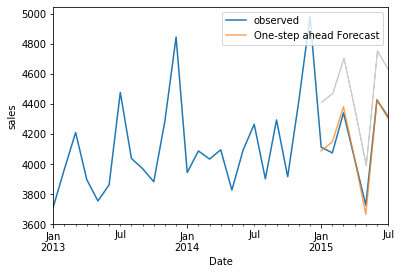

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   31
Model:             SARIMAX(5, 1, 3)x(1, 0, [], 12)   Log Likelihood                 -79.214
Date:                             Mon, 18 May 2020   AIC                            184.427
Time:                                     17:21:24   BIC                            191.771
Sample:                                 01-01-2013   HQIC                           182.917
                                      - 07-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019   3.73e+06  -5.19e-10      1.000   -7.31e+06    7.31e+06
Customers      8.9046    15

In [244]:
or_a = (5,1,3)
sord_a=(1, 0, 0, 12)
result_a,mse_a,rmse_a,rmspe_a= arima(y_sale_model_a,exog_a,or_a,sord_a)
print(result_a.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_a, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_a, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_a, 2)))

C:\Users\puj83\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


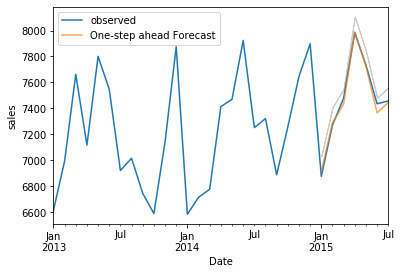

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   31
Model:             SARIMAX(3, 2, 3)x(1, 0, [], 12)   Log Likelihood                 -79.186
Date:                             Mon, 18 May 2020   AIC                            180.373
Time:                                     17:21:29   BIC                            187.402
Sample:                                 01-01-2013   HQIC                           179.722
                                      - 07-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201   1.89e+04   1.06e-06      1.000   -3.71e+04    3.71e+04
Customers      7.0233      

In [245]:
or_b = (3,2,3)
sord_b=(1, 0, 0, 12)
result_b,mse_b,rmse_b,rmspe_b= arima(y_sale_model_b,exog_b,or_b,sord_b)
print(result_b.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_b, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_b, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_b, 2)))

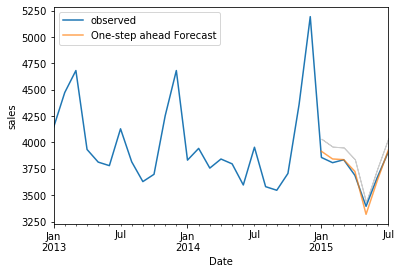

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   31
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                 -90.316
Date:                             Mon, 18 May 2020   AIC                            198.633
Time:                                     17:21:32   BIC                            205.586
Sample:                                 01-01-2013   HQIC                           198.989
                                      - 07-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0977   4316.011  -2.26e-05      1.000   -8459.324    8459.129
Customers      9.2331      

In [246]:
or_c = (2,1,2)
sord_c=(1, 0, 0, 12)
result_c,mse_c,rmse_c,rmspe_c= arima(y_sale_model_c,exog_c,or_c,sord_c)
print(result_c.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_c, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_c, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_c, 2)))

In [247]:
train_xg = df_train_store.sort_values(['Date'],ascending = False)
ho_test = df_train_store[:6*7*1115]
ho_train = df_train_store[6*7*1115:]

In [248]:
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

In [249]:
ho_train.drop(['Date','Open','PromoInterval','monthStr'],axis=1,inplace =True)
ho_test.drop(['Date','Open','PromoInterval','monthStr'],axis=1,inplace =True)
xtest =df_test_store.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)

In [250]:
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

In [251]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [252]:
dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [253]:
params = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 6000           #countinue for 6000 itertions


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))


print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[17:27:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:8.02223	eval-rmse:7.99044	train-rmspe:0.99981	eval-rmspe:0.99981
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78170	eval-rmse:7.75122	train-rmspe:0.99971	eval-rmspe:0.99971
[2]	train-rmse:7.54829	eval-rmse:7.51869	train-rmspe:0.99960	eval-rmspe:0.99959
[3]	train-rmse:7.32198	eval-rms

In [254]:
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.019853


In [255]:
df_predict = pd.DataFrame(yhat)
df_predict.head()

,0
0,8.569138
1,8.515738
2,8.468424
3,8.511622
4,8.707675


In [256]:
# analysis by hold-out set
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,555,1,0,1,3,1,1270.0,9.0,...,31,31,82.0,24187.75,0,8.568646,8.569138,1.000057,0.000057,0.999943
1,1,3,546,1,0,1,3,1,1270.0,9.0,...,30,31,82.0,24187.75,0,8.521384,8.515738,0.999337,0.000663,1.000663
2,1,2,523,1,0,1,3,1,1270.0,9.0,...,29,31,82.0,24187.75,0,8.472823,8.468424,0.999481,0.000519,1.000520
3,1,1,560,1,0,1,3,1,1270.0,9.0,...,28,31,82.0,24187.75,0,8.519590,8.511622,0.999065,0.000935,1.000936
4,1,0,612,1,0,1,3,1,1270.0,9.0,...,27,31,82.0,24187.75,0,8.716536,8.707675,0.998983,0.001017,1.001018


In [257]:
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
27666,30,0,93,0,0,0,1,1,40.0,2.0,...,11,7,0.0,0.00,0,6.418365,6.548179,1.020225,0.020225,0.980176
37545,42,5,785,0,0,0,1,3,290.0,0.0,...,4,27,24187.0,44.75,1,8.794522,8.669864,0.985825,0.014175,1.014378
35987,40,3,158,0,0,0,1,1,180.0,0.0,...,12,7,24182.0,62.50,1,6.959399,7.052344,1.013355,0.013355,0.986821
38028,42,5,1007,0,0,0,1,3,290.0,0.0,...,8,10,24171.0,28.50,0,9.066239,8.945184,0.986648,0.013352,1.013533
22588,25,4,2835,0,0,0,3,1,430.0,4.0,...,14,7,130.0,24169.75,0,10.121940,9.988248,0.986792,0.013208,1.013385
37783,42,5,1164,0,0,0,1,3,290.0,0.0,...,8,45,24179.0,37.25,0,9.210940,9.090712,0.986947,0.013053,1.013225
37972,42,5,1013,0,0,0,1,3,290.0,0.0,...,3,18,24173.0,30.50,0,9.071538,8.953154,0.986950,0.013050,1.013223
37594,42,5,891,0,0,0,1,3,290.0,0.0,...,16,20,24185.0,43.00,0,8.946635,8.830060,0.986970,0.013030,1.013202
37979,42,5,895,0,0,0,1,3,290.0,0.0,...,26,17,24172.0,30.25,1,8.935114,8.819846,0.987099,0.012901,1.013069
37647,42,1,1021,0,0,0,1,3,290.0,0.0,...,24,13,24183.0,41.25,0,9.071997,8.955207,0.987126,0.012874,1.013042


weight correction
RMSPE for 0.990:0.087112
RMSPE for 0.991:0.079320
RMSPE for 0.992:0.071510
RMSPE for 0.993:0.063704
RMSPE for 0.994:0.055934
RMSPE for 0.995:0.048252
RMSPE for 0.996:0.040754
RMSPE for 0.997:0.033616
RMSPE for 0.998:0.027192
RMSPE for 0.999:0.022199
RMSPE for 1.000:0.019853
RMSPE for 1.001:0.021151
RMSPE for 1.002:0.025621
RMSPE for 1.003:0.032024
RMSPE for 1.004:0.039482
RMSPE for 1.005:0.047547
RMSPE for 1.006:0.055995
RMSPE for 1.007:0.064710
RMSPE for 1.008:0.073631
RMSPE for 1.009:0.082716
Best weight for Score:1.0    0.019853
dtype: float64


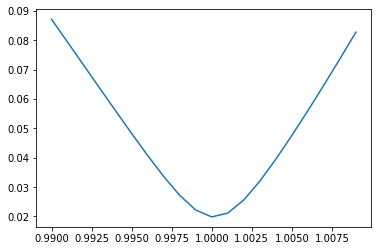

In [258]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [260]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']

In [261]:
# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [262]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.012408


In [263]:
df_test_store.drop(['Id'],axis=1,inplace=True)